# Objects in boxes

This tutorial includes everything you need to set up IBM Decision Optimization CPLEX Modeling for Python (DOcplex), build a Mathematical Programming model, and get its solution by solving the model on the cloud with IBM ILOG CPLEX Optimizer.

When you finish this tutorial, you'll have a foundational knowledge of _Prescriptive Analytics_.

>This notebook is part of [Prescriptive Analytics for Python](http://ibmdecisionoptimization.github.io/docplex-doc/)
>
>It requires either an [installation of CPLEX Optimizers](http://ibmdecisionoptimization.github.io/docplex-doc/getting_started.html) or it can be run on [IBM Cloud Pak for Data as a Service](https://www.ibm.com/products/cloud-pak-for-data/as-a-service/) (Sign up for a [free IBM Cloud account](https://dataplatform.cloud.ibm.com/registration/stepone?context=wdp&apps=all>)
and you can start using `IBM Cloud Pak for Data as a Service` right away).
>
> CPLEX is available on <i>IBM Cloud Pack for Data</i> and <i>IBM Cloud Pak for Data as a Service</i>:
>    - <i>IBM Cloud Pak for Data as a Service</i>: Depends on the runtime used:
>         - <i>Python 3.x</i> runtime: Community edition
>         - <i>Python 3.x + DO</i> runtime: full edition
>    - <i>Cloud Pack for Data</i>: Community edition is installed by default. Please install `DO` addon in `Watson Studio Premium` for the full edition



Table of contents:

* [Describe the business problem](#Describe-the-business-problem)
* [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
* [Use decision optimization](#Use-decision-optimization)
    * [Step 1: Import the library](#Step-1:-Import-the-library)
    * [Step 2: Model the data](#Step-2:-Model-the-data)
    * [Step 3: Prepare the data](#Step-3:-Prepare-the-data)
    * [Step 4: Set up the prescriptive model](#Step-4:-Set-up-the-prescriptive-model)
        * [Define the decision variables](#Define-the-decision-variables)
        * [Express the business constraints](#Express-the-business-constraints)
        * [Express the objective](#Express-the-objective)
        * [Solve the model](#Solve-the-model)
    * [Step 5: Investigate the solution and run an example analysis](#Step-5:-Investigate-the-solution-and-then-run-an-example-analysis)
* [Summary](#Summary)

****

## Describe the business problem

* We wish to put $N$ objects which are scattered in the plane, into a row of $N$ boxes.

* Boxes are aligned from left to right (if $i < i'$, box $i$ is to the left of box $i'$) on the $x$ axis.
* Box $i$ is located at a point $B_i$ of the $(x,y)$ plane and object $j$ is located at $O_j$.


* We want to find an arrangement of objects such that:
    * each box contains exactly one object,
    * each object is stored in one box,
    * the total distance from object $j$ to its storage box is minimal.


* First, we solve the problem described, and then we add two new constraints and examine how the cost (and solution) changes.
    * From the first solution, we impose that object #1 is assigned to the box immediately to the left of object #2.
    * Then we impose that object #5 is assigned to a box next to the box of object #6.

## How  decision optimization can help

* Prescriptive analytics (decision optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate the complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.

## Use decision optimization

### Step 1: Import the library

Run the following code to import the Decision Optimization CPLEX Modeling library.  The *DOcplex* library contains the two modeling packages, Mathematical Programming and Constraint Programming, referred to earlier.

In [1]:
import sys
try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')      

If *CPLEX* is not installed, please install CPLEX Community edition.

In [2]:
try:
    import cplex
except:
    raise Exception('Please install CPLEX. See https://pypi.org/project/cplex/')

### Step 2: Model the data

The input data is the number of objects (and boxes) _N_, and their positions in the (x,y) plane.

### Step 3: Prepare the data

We use Euclidean distance to compute the distance between an object and its assigned box.



In [3]:
from math import sqrt

N = 15
box_range = range(1, N+1)
obj_range = range(1, N+1)

import random

o_xmax = N*10
o_ymax = 2*N
box_coords = {b: (10*b, 1) for b in box_range}

obj_coords= {1: (140, 6), 2: (146, 8), 3: (132, 14), 4: (53, 28), 
             5: (146, 4), 6: (137, 13), 7: (95, 12), 8: (68, 9), 9: (102, 18), 
             10: (116, 8), 11: (19, 29), 12: (89, 15), 13: (141, 4), 14: (29, 4), 15: (4, 28)}

# the distance matrix from box i to object j
# actually we compute the square of distance to keep integer
# this does not change the essence of the problem
distances = {}
for o in obj_range:
    for b in box_range:
        dx = obj_coords[o][0]-box_coords[b][0]
        dy = obj_coords[o][1]-box_coords[b][1]
        d2 = dx*dx + dy*dy
        distances[b, o] = d2

### Step 4: Set up the prescriptive model

In [4]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Windows 64bit
* Python version 3.8.5, located at: c:\Users\ACER\miniconda3\python.exe
* docplex is present, version is 2.22.213
* CPLEX library is present, version is 20.1.0.0, located at: c:\Users\ACER\miniconda3\lib\site-packages
* pandas is present, version is 1.3.1


#### Create the DOcplex model
The model contains all the business constraints and defines the objective.

In [5]:
from docplex.mp.model import Model

mdl = Model("boxes")

#### Define the decision variables

* For each box $i$ ($i$ in $1..N$) and object $j$ ($j$ in $1..N$), we define a binary variable $X_{i,j}$ equal to $1$ if and only if object $j$ is stored in box $i$.

In [6]:
# decision variables is a 2d-matrix
x = mdl.binary_var_matrix(box_range, obj_range, lambda ij: "x_%d_%d" %(ij[0], ij[1]))

#### Express the business constraints

* The sum of $X_{i,j}$ over both rows and columns must be equal to $1$, resulting in $2\times N$ constraints.

In [7]:
# one object per box
mdl.add_constraints(mdl.sum(x[i,j] for j in obj_range) == 1
                   for i in box_range)
    
# one box for each object
mdl.add_constraints(mdl.sum(x[i,j] for i in box_range) == 1
                  for j in obj_range)

mdl.print_information()

Model: boxes
 - number of variables: 225
   - binary=225, integer=0, continuous=0
 - number of constraints: 30
   - linear=30
 - parameters: defaults
 - objective: none
 - problem type is: MILP


#### Express the objective

* The objective is to minimize the total distance between each object and its storage box.

In [8]:
# minimize total displacement
mdl.minimize( mdl.sum(distances[i,j] * x[i,j] for i in box_range for j in obj_range) )

#### Solve the model


In [9]:
mdl.print_information()

assert mdl.solve(), "!!! Solve of the model fails"

Model: boxes
 - number of variables: 225
   - binary=225, integer=0, continuous=0
 - number of constraints: 30
   - linear=30
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [10]:
mdl.report()
d1 = mdl.objective_value
#mdl.print_solution()

def make_solution_vector(x_vars):
    sol = [0]* N
    for i in box_range:
        for j in obj_range:
            if x[i,j].solution_value >= 0.5:
                sol[i-1] = j
                break
    return sol

def make_obj_box_dir(sol_vec):
    # sol_vec contains an array of objects in box order at slot b-1 we have obj(b)
    return { sol_vec[b]: b+1 for b in range(N)}
    
               
sol1 = make_solution_vector(x)
print("* solution: {0!s}".format(sol1))          

* model boxes solved with objective = 8858.000
* solution: [15, 11, 14, 4, 8, 12, 7, 9, 10, 3, 6, 1, 13, 2, 5]


#### Additional constraint #1

As an additional constraint, we want to impose that object #1 is stored immediately to the left of object #2.
As a consequence, object #2 cannot be stored in box #1, so we add:

In [11]:
mdl.add_constraint(x[1,2] == 0)

docplex.mp.LinearConstraint[](x_1_2,EQ,0)

Now, we must state that for $k \geq 2$ if $x[k,2] == 1$ then $x[k-1,1] == 1$; this is a logical implication that we express by a relational operator:

In [12]:
mdl.add_constraints(x[k-1,1] >= x[k,2]
                   for k in range(2,N+1))
mdl.print_information()

Model: boxes
 - number of variables: 225
   - binary=225, integer=0, continuous=0
 - number of constraints: 45
   - linear=45
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


Now let's solve again and check that our new constraint is satisfied, that is, object #1 is immediately left to object #2

In [13]:
ok2 = mdl.solve()
assert ok2, "solve failed"
mdl.report()
d2 = mdl.objective_value
sol2 = make_solution_vector(x)
print(" solution #2 ={0!s}".format(sol2))

* model boxes solved with objective = 8878.000
 solution #2 =[15, 11, 14, 4, 8, 12, 7, 9, 10, 3, 6, 13, 1, 2, 5]


The constraint is indeed satisfied, with a higher objective, as expected.

#### Additional constraint #2

Now, we want to add a second constraint to state that object #5 is stored in a box that is next to the box of object #6, either to the left or right.

In other words, when $x[k,6]$ is equal to $1$, then one of $x[k-1,5]$ and $x[k+1,5]$ is equal to $1$;
this is again a logical implication, with an OR in the right side.

We have to handle the case of extremities with care.

In [14]:
# forall k in 2..N-1 then we can use the sum on the right hand side
mdl.add_constraints(x[k,6] <= x[k-1,5] + x[k+1,5]
                  for k in range(2,N))
    
# if 6 is in box 1 then 5 must be in 2
mdl.add_constraint(x[1,6] <= x[2,5])

# if 6 is last, then 5 must be before last
mdl.add_constraint(x[N,6] <= x[N-1,5])

# we solve again
ok3 = mdl.solve()
assert ok3, "solve failed"
mdl.report()
d3 = mdl.objective_value

sol3 = make_solution_vector(x)
print(" solution #3 ={0!s}".format(sol3)) 

* model boxes solved with objective = 9078.000
 solution #3 =[15, 11, 14, 4, 8, 12, 7, 9, 10, 3, 13, 6, 5, 1, 2]


As expected, the constraint is satisfied; objects #5 and #6 are next to each other.
Predictably, the objective is higher.

### Step 5: Investigate the solution and then run an example analysis

Present the solution as a vector of object indices, sorted by box indices.
We use maptplotlib to display the assignment of objects to boxes.


In [15]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12, 6

def display_solution(sol):
    obj_boxes = make_obj_box_dir(sol)
    xs = []
    ys = []
    for o in obj_range:
        b = obj_boxes[o]
        box_x = box_coords[b][0]
        box_y = box_coords[b][1]
        obj_x = obj_coords[o][0]
        obj_y = obj_coords[o][1]
        plt.text(obj_x, obj_y, str(o), bbox=dict(facecolor='red', alpha=0.5))
        plt.plot([obj_x, box_x], [obj_y, box_y])


The first solution shows no segments crossing, which is to be expected.

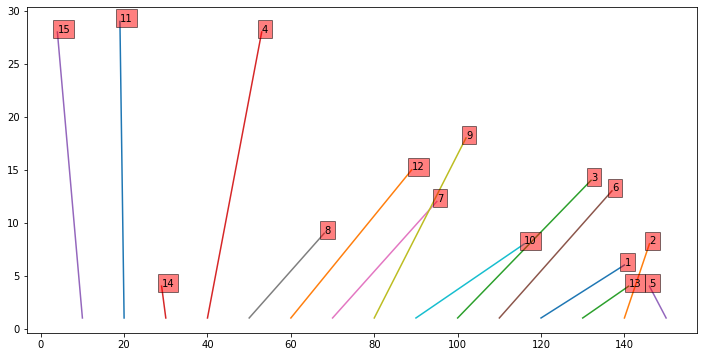

In [16]:
display_solution(sol1)

The second solution, by enforcing that object #1 must be to the left of object #2, introduces crossings.

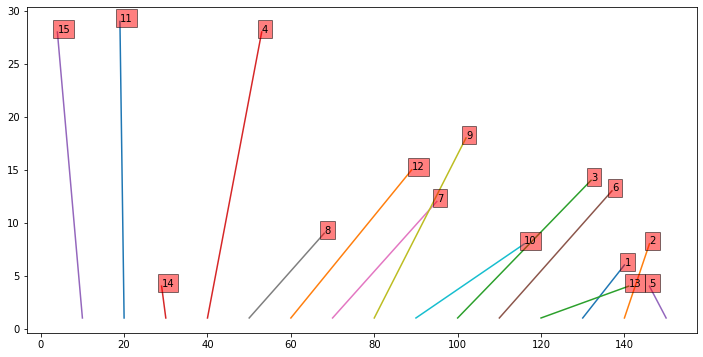

In [17]:
display_solution(sol2)

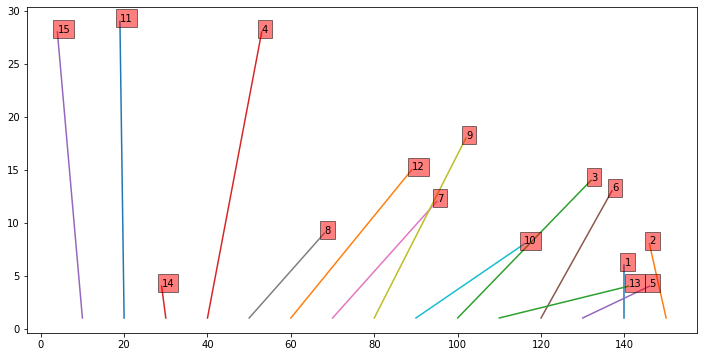

In [18]:
display_solution(sol3)

OrderedDict([('d1', 858.0), ('d2', 878.0), ('d3', 1078.0)])


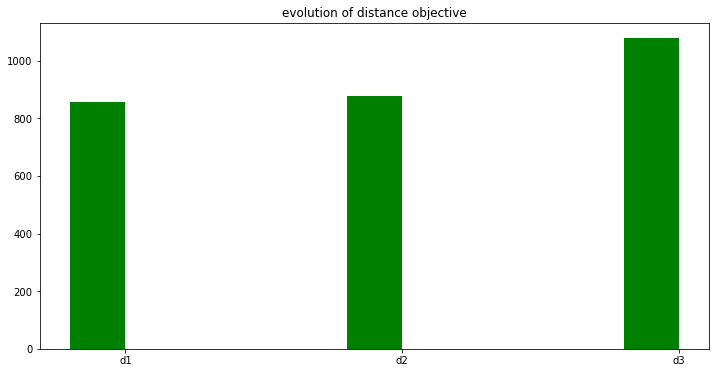

In [19]:

def display(myDict, title):
    if True: #env.has_matplotlib:
        N = len(myDict)
        labels = myDict.keys()
        values= myDict.values()

        try: # Python 2
            ind = xrange(N)  # the x locations for the groups
        except: # Python 3
            ind = range(N)
        width = 0.2      # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(ind, values, width, color='g')	
        ax.set_title(title)
        ax.set_xticks([ind[i]+width/2 for i in ind])
        ax.set_xticklabels( labels )	
        #ax.legend( (rects1[0]), (title) )

        plt.show()
    else:
        print("warning: no display")
        
from collections import OrderedDict
dists = OrderedDict()
dists["d1"]= d1 -8000
dists["d2"] = d2 - 8000
dists["d3"] = d3 - 8000
print(dists)

display(dists, "evolution of distance objective")

## Summary

You learned how to set up and use IBM Decision Optimization CPLEX Modeling for Python to formulate a Mathematical Programming model and solve it with CPLEX.

## References
* [CPLEX Modeling for Python documentation](http://ibmdecisionoptimization.github.io/docplex-doc/)
* [IBM Decision Optimization](https://www.ibm.com/analytics/decision-optimization)
* Need help with DOcplex or to report a bug? Please go [here](https://stackoverflow.com/questions/tagged/docplex).
* Contact us at dofeedback@wwpdl.vnet.ibm.com.

Copyright &copy; 2017-2019 IBM. IPLA licensed Sample Materials.